<a href="https://colab.research.google.com/github/rehabib/PRECISE-Africa-Breast-Ultrasound-Segmentation-and-Classification-Challenge-PACE-/blob/main/Breast_cancer_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.listdir('/content/drive/MyDrive/new_dataset-20250821T013931Z-1-001/new_dataset')

['benign', 'malignant', 'normal']

In [ ]:
# ============================================
# 1. Imports
# ============================================
import os
import numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from PIL import Image

from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import directed_hausdorff


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms

class BreastDataset(Dataset):
    def __init__(self, img_paths, mask_paths, labels, size=(256, 256)):
        # Save paths and labels
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.size = size

        # Image transform
        self.transform_img = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        # Mask transform
        self.transform_mask = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Open image and mask
        img = Image.open(self.img_paths[idx]).convert('L')    # grayscale
        mask = Image.open(self.mask_paths[idx]).convert('L')  # single channel
        label = self.labels[idx]

        # Apply transforms
        img = self.transform_img(img)     # [1, H, W]
        mask = self.transform_mask(mask)  # [1, H, W]

        # Ensure all tensors have same batchable shape
        return img, mask, torch.tensor(label, dtype=torch.long)


In [ ]:
# ============================================
# ============================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # pad if mismatch
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX//2,
                      diffY // 2, diffY - diffY//2])
        return self.conv(torch.cat([skip, x], dim=1))

class MultiTaskUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, base_ch=32):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch*8, base_ch*16)

        # Decoder (segmentation)
        self.up4 = UpBlock(base_ch*16, base_ch*8)
        self.up3 = UpBlock(base_ch*8, base_ch*4)
        self.up2 = UpBlock(base_ch*4, base_ch*2)
        self.up1 = UpBlock(base_ch*2, base_ch)
        self.seg_head = nn.Conv2d(base_ch, 1, kernel_size=1)

        # Classification head
        self.cls_gap = nn.AdaptiveAvgPool2d((1,1))
        self.cls_fc = nn.Linear(base_ch*16, num_classes)

    def forward(self, x):
        # Encoder
        s1 = self.enc1(x); p1 = self.pool1(s1)
        s2 = self.enc2(p1); p2 = self.pool2(s2)
        s3 = self.enc3(p2); p3 = self.pool3(s3)
        s4 = self.enc4(p3); p4 = self.pool4(s4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.up4(b, s4)
        d3 = self.up3(d4, s3)
        d2 = self.up2(d3, s2)
        d1 = self.up1(d2, s1)
        seg = self.seg_head(d1)

        # Classification
        cls = self.cls_gap(b).flatten(1)
        cls = self.cls_fc(cls)

        return seg, cls


In [ ]:
# ============================================
# 4. Metrics
# ============================================
import torch
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def dice_score(pred, target, eps=1e-6):
    """Dice score for a single prediction/target pair"""
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    inter = (pred & target).float().sum()
    union = pred.float().sum() + target.float().sum()
    return (2 * inter + eps) / (union + eps)


def iou_score(pred, target, eps=1e-6):
    """IoU score for a single prediction/target pair"""
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    inter = (pred & target).float().sum()
    union = (pred | target).float().sum()
    return (inter + eps) / (union + eps)


def hausdorff_distance(pred, target, max_hd=1000.0):
    """
    Symmetric Hausdorff distance between prediction and target masks.
    If one mask is empty, returns max_hd instead of inf.
    """
    pred = (torch.sigmoid(pred) > 0.5).cpu().numpy().astype(np.uint8).squeeze()
    target = (target > 0.5).cpu().numpy().astype(np.uint8).squeeze()

    pred_pts = np.argwhere(pred)
    target_pts = np.argwhere(target)

    if len(pred_pts) == 0 or len(target_pts) == 0:
        return max_hd

    hd1 = directed_hausdorff(pred_pts, target_pts)[0]
    hd2 = directed_hausdorff(target_pts, pred_pts)[0]
    return max(hd1, hd2)


def average_metrics(batch_preds, batch_targets):
    """
    Compute mean Dice, IoU, HD over a batch.
    Args:
        batch_preds: tensor of shape (B,1,H,W)
        batch_targets: tensor of shape (B,1,H,W)
    """
    dice_vals, iou_vals, hd_vals = [], [], []
    for pred, target in zip(batch_preds, batch_targets):
        dice_vals.append(dice_score(pred, target).item())
        iou_vals.append(iou_score(pred, target).item())
        hd_vals.append(hausdorff_distance(pred, target))

    return {
        "dice": np.mean(dice_vals),
        "iou": np.mean(iou_vals),
        "hd": np.mean(hd_vals),
    }


In [ ]:
# ============================================
# 5. Training & Validation Loops
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, cls_loss_fn, seg_loss_fn, lambda_seg=0.6):
    model.train()
    total_loss, total_dice = 0.0, 0.0

    for imgs, masks, labels in tqdm(loader, desc="Train"):
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
        seg_logits, cls_logits = model(imgs)

        # Segmentation loss
        seg_loss = 0.5 * F.binary_cross_entropy_with_logits(seg_logits, masks) \
                 + 0.5 * seg_loss_fn(seg_logits, masks)

        # Classification loss
        cls_loss = cls_loss_fn(cls_logits, labels)

        # Weighted multitask loss
        loss = lambda_seg * seg_loss + (1 - lambda_seg) * cls_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_score(seg_logits, masks).item()

    return total_loss / len(loader), total_dice / len(loader)


@torch.no_grad()
def validate(model, loader, cls_loss_fn, seg_loss_fn, lambda_seg=0.6):
    model.eval()
    total_loss, total_dice, total_iou, total_hd = 0.0, 0.0, 0.0, 0.0
    all_labels, all_preds = [], []

    for imgs, masks, labels in tqdm(loader, desc="Val"):
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
        seg_logits, cls_logits = model(imgs)

        seg_loss = 0.5 * F.binary_cross_entropy_with_logits(seg_logits, masks) \
                 + 0.5 * seg_loss_fn(seg_logits, masks)
        cls_loss = cls_loss_fn(cls_logits, labels)
        loss = lambda_seg * seg_loss + (1 - lambda_seg) * cls_loss

        total_loss += loss.item()
        total_dice += dice_score(seg_logits, masks).item()
        total_iou += iou_score(seg_logits, masks).item()
        total_hd += hausdorff_distance(seg_logits, masks)

        all_labels.extend(labels.cpu().numpy())

        # Multi-class handling
        probs = torch.softmax(cls_logits, dim=1).cpu().numpy()
        if cls_logits.shape[1] == 2:  # binary classification
            all_preds.extend(probs[:, 1])
        else:  # multi-class
            all_preds.extend(probs)  # keep full prob array for multi-class AUC

    # Compute AUC
    try:
        if cls_logits.shape[1] == 2:
            auc = roc_auc_score(all_labels, all_preds)
        else:
            auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    except:
        auc = float('nan')  # fallback in case of error

    return total_loss / len(loader), total_dice / len(loader), total_iou / len(loader), total_hd / len(loader), auc


In [ ]:
import os
from glob import glob

img_paths, mask_paths, labels = [], [], []

base_dir = "/content/drive/MyDrive/new_dataset-20250821T013931Z-1-001/new_dataset"
label_map = {'normal': 0, 'benign': 1, 'malignant': 2}

for label_name, label_id in label_map.items():
    folder = os.path.join(base_dir, label_name)
    all_images = sorted(glob(f"{folder}/*.png"))

    for img_file in all_images:
        if "_mask" in img_file:  # skip masks
            continue

        base_name = os.path.splitext(os.path.basename(img_file))[0]
        candidate_masks = glob(os.path.join(folder, f"{base_name}_mask*.png"))

        if len(candidate_masks) == 0:
            print(f"⚠️ No mask found for {img_file}")
            continue

        img_paths.append(img_file)
        mask_paths.append(candidate_masks[0])
        labels.append(label_id)

print(f"✅ Found {len(img_paths)} images with at least one mask")


✅ Found 5332 images with at least one mask


In [ ]:
# ============================================
# Dice Loss (differentiable) for segmentation
# ============================================
def dice_loss(pred, target, eps=1e-6):
    """
    Computes differentiable Dice loss.
    pred: raw logits from model
    target: ground truth mask (0/1)
    """
    pred = torch.sigmoid(pred)           # convert logits to probabilities
    target = target.float()              # ensure float type
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2 * inter + eps) / (union + eps)


In [ ]:
# ============================================
# 6. Main Training Loop with Early Stopping
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Initialize model + optimizer
# ----------------------------
model = MultiTaskUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cls_loss_fn = nn.CrossEntropyLoss()
seg_loss_fn = dice_loss  # now differentiable

# ----------------------------
# Build dataset using prepared lists
# ----------------------------
# Make sure BreastDataset resizes images to 256x256 or desired size
dataset = BreastDataset(img_paths, mask_paths, labels, size=(256,256))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=8, num_workers=0)

# ----------------------------
# Training Loop with Early Stopping
# ----------------------------
best_val_loss = np.inf
patience, patience_counter = 5, 0

for epoch in range(1, 51):
    print(f"\nEpoch {epoch}")

    # Training
    train_loss, train_dice = train_one_epoch(
        model, train_loader, optimizer, cls_loss_fn, seg_loss_fn
    )

    # Validation
    val_loss, val_dice, val_iou, val_hd, val_auc = validate(
        model, val_loader, cls_loss_fn, seg_loss_fn
    )

    print(f"Train Loss {train_loss:.4f} | Dice {train_dice:.4f}")
    print(f"Val   Loss {val_loss:.4f} | Dice {val_dice:.4f} | "
          f"IoU {val_iou:.4f} | HD {val_hd:.2f} | AUC {val_auc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "content/drive/mydrive/best_multitask_unet.pth")
        patience_counter = 0
        print("✅ Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered")
            break



Epoch 1


Val: 100%|██████████| 134/134 [26:47<00:00, 11.99s/it]


Train Loss 0.6956 | Dice 0.2855
Val   Loss 0.6476 | Dice 0.3823 | IoU 0.2485 | HD 70.32 | AUC 0.7927
✅ Saved new best model

Epoch 2


Val: 100%|██████████| 134/134 [00:29<00:00,  4.55it/s]


Train Loss 0.5247 | Dice 0.5252
Val   Loss 0.4507 | Dice 0.5498 | IoU 0.3921 | HD 63.03 | AUC 0.8928
✅ Saved new best model

Epoch 3


Val: 100%|██████████| 134/134 [00:30<00:00,  4.44it/s]


Train Loss 0.4485 | Dice 0.6002
Val   Loss 0.4229 | Dice 0.6199 | IoU 0.4586 | HD 56.95 | AUC 0.9109
✅ Saved new best model

Epoch 4


Val: 100%|██████████| 134/134 [00:31<00:00,  4.26it/s]


Train Loss 0.4181 | Dice 0.6249
Val   Loss 0.4663 | Dice 0.6187 | IoU 0.4617 | HD 62.50 | AUC 0.9002

Epoch 5


Val: 100%|██████████| 134/134 [00:30<00:00,  4.32it/s]


Train Loss 0.3896 | Dice 0.6483
Val   Loss 0.4188 | Dice 0.6688 | IoU 0.5144 | HD 51.75 | AUC 0.9333
✅ Saved new best model

Epoch 6


Val: 100%|██████████| 134/134 [00:30<00:00,  4.35it/s]


Train Loss 0.3706 | Dice 0.6608
Val   Loss 0.3932 | Dice 0.6478 | IoU 0.4910 | HD 54.45 | AUC 0.9183
✅ Saved new best model

Epoch 7


Val: 100%|██████████| 134/134 [00:30<00:00,  4.37it/s]


Train Loss 0.3485 | Dice 0.6779
Val   Loss 0.3100 | Dice 0.6828 | IoU 0.5302 | HD 53.28 | AUC 0.9458
✅ Saved new best model

Epoch 8


Val: 100%|██████████| 134/134 [00:30<00:00,  4.43it/s]


Train Loss 0.3188 | Dice 0.6989
Val   Loss 0.3053 | Dice 0.6838 | IoU 0.5307 | HD 53.92 | AUC 0.9550
✅ Saved new best model

Epoch 9


Val: 100%|██████████| 134/134 [00:31<00:00,  4.27it/s]


Train Loss 0.3087 | Dice 0.7062
Val   Loss 0.3260 | Dice 0.6862 | IoU 0.5328 | HD 56.05 | AUC 0.9399

Epoch 10


Val: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Train Loss 0.2905 | Dice 0.7180
Val   Loss 0.2813 | Dice 0.6965 | IoU 0.5466 | HD 55.20 | AUC 0.9581
✅ Saved new best model

Epoch 11


Val: 100%|██████████| 134/134 [00:32<00:00,  4.15it/s]


Train Loss 0.2736 | Dice 0.7269
Val   Loss 0.3175 | Dice 0.6974 | IoU 0.5509 | HD 54.04 | AUC 0.9475

Epoch 12


Val: 100%|██████████| 134/134 [00:31<00:00,  4.25it/s]


Train Loss 0.2534 | Dice 0.7403
Val   Loss 0.3968 | Dice 0.7090 | IoU 0.5611 | HD 59.77 | AUC 0.9373

Epoch 13


Val: 100%|██████████| 134/134 [00:32<00:00,  4.06it/s]


Train Loss 0.2423 | Dice 0.7527
Val   Loss 0.2720 | Dice 0.7330 | IoU 0.5924 | HD 51.14 | AUC 0.9628
✅ Saved new best model

Epoch 14


Val: 100%|██████████| 134/134 [00:31<00:00,  4.24it/s]


Train Loss 0.2204 | Dice 0.7652
Val   Loss 0.2692 | Dice 0.7432 | IoU 0.6021 | HD 52.47 | AUC 0.9599
✅ Saved new best model

Epoch 15


Val: 100%|██████████| 134/134 [00:30<00:00,  4.33it/s]


Train Loss 0.2089 | Dice 0.7722
Val   Loss 0.2374 | Dice 0.7549 | IoU 0.6193 | HD 53.93 | AUC 0.9707
✅ Saved new best model

Epoch 16


Val: 100%|██████████| 134/134 [00:30<00:00,  4.42it/s]


Train Loss 0.1916 | Dice 0.7854
Val   Loss 0.2844 | Dice 0.7490 | IoU 0.6103 | HD 52.79 | AUC 0.9607

Epoch 17


Val: 100%|██████████| 134/134 [00:30<00:00,  4.45it/s]


Train Loss 0.1807 | Dice 0.7929
Val   Loss 0.2402 | Dice 0.7619 | IoU 0.6272 | HD 51.35 | AUC 0.9666

Epoch 18


Val: 100%|██████████| 134/134 [00:30<00:00,  4.44it/s]


Train Loss 0.1674 | Dice 0.7973
Val   Loss 0.4017 | Dice 0.7429 | IoU 0.6033 | HD 49.60 | AUC 0.9567

Epoch 19


Val: 100%|██████████| 134/134 [00:31<00:00,  4.32it/s]


Train Loss 0.1541 | Dice 0.8049
Val   Loss 0.2094 | Dice 0.7831 | IoU 0.6534 | HD 49.07 | AUC 0.9770
✅ Saved new best model

Epoch 20


Val: 100%|██████████| 134/134 [00:30<00:00,  4.38it/s]


Train Loss 0.1603 | Dice 0.8088
Val   Loss 0.2235 | Dice 0.7785 | IoU 0.6488 | HD 50.46 | AUC 0.9712

Epoch 21


Val: 100%|██████████| 134/134 [00:31<00:00,  4.29it/s]


Train Loss 0.1349 | Dice 0.8293
Val   Loss 0.2575 | Dice 0.7946 | IoU 0.6697 | HD 46.29 | AUC 0.9750

Epoch 22


Val: 100%|██████████| 134/134 [00:30<00:00,  4.43it/s]


Train Loss 0.1302 | Dice 0.8301
Val   Loss 0.3262 | Dice 0.7768 | IoU 0.6461 | HD 49.63 | AUC 0.9579

Epoch 23


Val: 100%|██████████| 134/134 [00:30<00:00,  4.42it/s]


Train Loss 0.1138 | Dice 0.8402
Val   Loss 0.2280 | Dice 0.7856 | IoU 0.6568 | HD 50.68 | AUC 0.9717

Epoch 24


Val: 100%|██████████| 134/134 [00:30<00:00,  4.40it/s]

Train Loss 0.1069 | Dice 0.8454
Val   Loss 0.2459 | Dice 0.7830 | IoU 0.6550 | HD 49.19 | AUC 0.9760
⏹️ Early stopping triggered


In [ ]:
# ============================================
# 7. Inference on New Images
# ============================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ----------------------------
# Load trained model
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiTaskUNet().to(device)
model.load_state_dict(torch.load("best_multitask_unet.pth", map_location=device))
model.eval()

# ----------------------------
# Define same transforms as training
# ----------------------------
infer_transform_img = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

infer_transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

# ----------------------------
# Inference function
# ----------------------------
def infer_one_image(img_path):
    # Load and preprocess image
    img = Image.open(img_path).convert("L")   # force grayscale
    img_tensor = infer_transform_img(img).unsqueeze(0).to(device)  # [1, 1, 256, 256]

    with torch.no_grad():
        seg_logits, cls_logits = model(img_tensor)

        # Segmentation output
        seg_prob = torch.sigmoid(seg_logits)        # [1, 1, 256, 256]
        seg_mask = (seg_prob > 0.5).float().cpu().squeeze().numpy()

        # Classification output
        probs = torch.softmax(cls_logits, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(probs)

    return img, seg_mask, probs, pred_class

# ----------------------------
# Example usage
# ----------------------------
test_image_path = "path/to/your/test_image.png"   # change this
img, pred_mask, cls_probs, pred_class = infer_one_image(test_image_path)

print(f"Classification probabilities: {cls_probs}")
print(f"Predicted class: {pred_class}")

# ----------------------------
# Visualization
# ----------------------------
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()


NameError: name 'MultiTaskUNet' is not defined

In [ ]:


# ============================================
# 1. Prepare Dataset from Original Structure
# ============================================

img_paths = []
mask_paths = []
labels = []

base_dir = "/content/drive/MyDrive/new_dataset-20250821T013931Z-1-001/new_dataset"
label_map = {'normal': 0, 'benign': 1, 'malignant': 2}

for label_name in label_map:
    folder = os.path.join(base_dir, label_name)
    all_files = sorted(glob(f"{folder}/*.png"))

    for f in all_files:
        if "_mask" not in f:
            base_name = os.path.basename(f).replace(".png", "")
            mask_name = f"{base_name}_mask.png"
            mask_path = os.path.join(folder, mask_name)

            if os.path.exists(mask_path):
                img_paths.append(f)
                mask_paths.append(mask_path)
                labels.append(label_map[label_name])

# ============================================
# 2. Initialize Model and Training Components
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cls_loss_fn = torch.nn.CrossEntropyLoss()
seg_loss_fn = dice_loss

# ============================================
# 3. Create Dataset and DataLoaders
# ============================================

dataset = BreastDataset(img_paths, mask_paths, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

# ============================================
# 4. Training Loop with Early Stopping
# ============================================

best_val_loss = np.inf
patience, patience_counter = 5, 0

for epoch in range(1, 51):
    print(f"Epoch {epoch}")
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, cls_loss_fn, seg_loss_fn)
    val_loss, val_dice, val_iou, val_hd, val_auc = validate(model, val_loader, cls_loss_fn, seg_loss_fn)

    print(f"Train Loss {train_loss:.4f} | Dice {train_dice:.4f}")
    print(f"Val   Loss {val_loss:.4f} | Dice {val_dice:.4f} | IoU {val_iou:.4f} | HD {val_hd:.2f} | AUC {val_auc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_multitask_unet.pth")
        patience_counter = 0
        print("✅ Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered")
            break


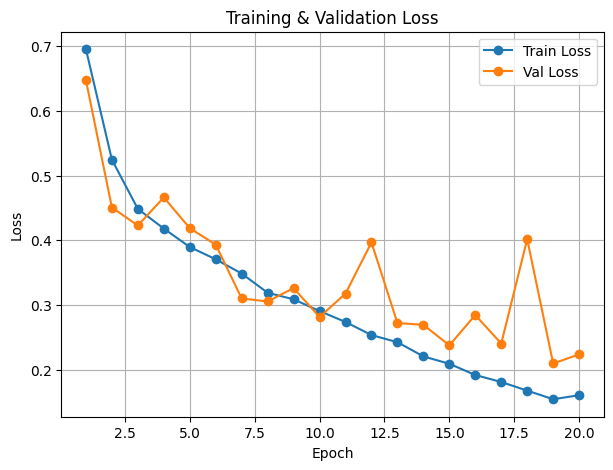

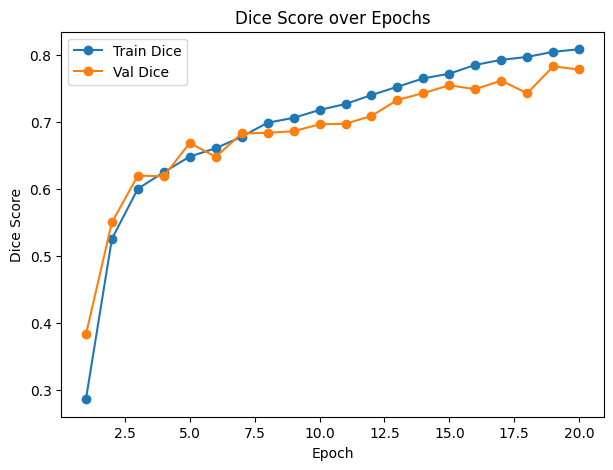

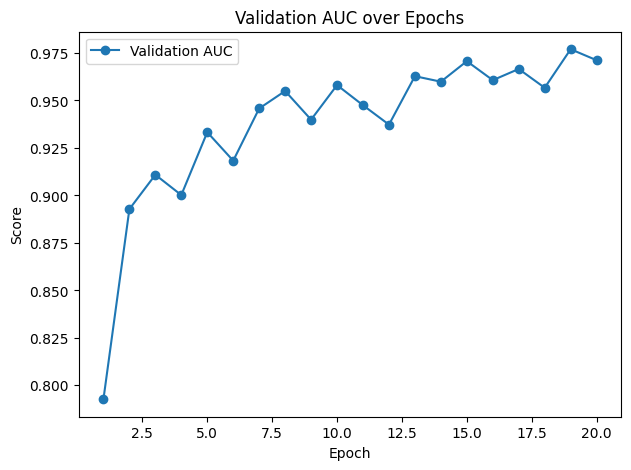

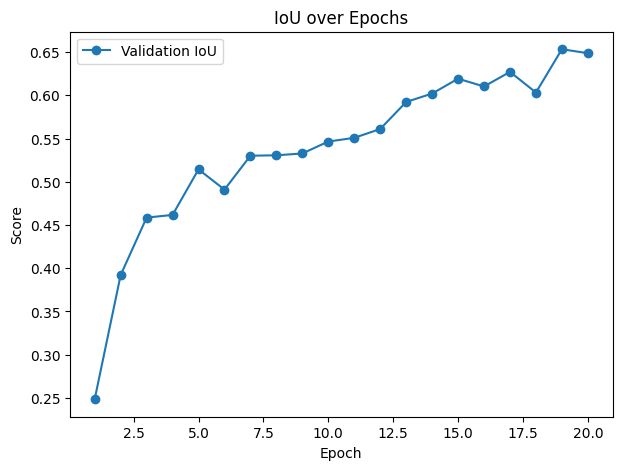

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))

train_loss = [0.6956, 0.5247, 0.4485, 0.4181, 0.3896, 0.3706, 0.3485, 0.3188, 0.3087,
              0.2905, 0.2736, 0.2534, 0.2423, 0.2204, 0.2089, 0.1916, 0.1807, 0.1674,
              0.1541, 0.1603]

val_loss   = [0.6476, 0.4507, 0.4229, 0.4663, 0.4188, 0.3932, 0.3100, 0.3053, 0.3260,
              0.2813, 0.3175, 0.3968, 0.2720, 0.2692, 0.2374, 0.2844, 0.2402, 0.4017,
              0.2094, 0.2235]

train_dice =  [0.2855, 0.5252, 0.6002, 0.6249, 0.6483, 0.6608, 0.6779, 0.6989, 0.7062,
              0.7180, 0.7269, 0.7403, 0.7527, 0.7652, 0.7722, 0.7854, 0.7929, 0.7973,
              0.8049, 0.8088]

val_dice   = [0.3823, 0.5498, 0.6199, 0.6187, 0.6688, 0.6478, 0.6828, 0.6838, 0.6862,
              0.6965, 0.6974, 0.7090, 0.7330, 0.7432, 0.7549, 0.7490, 0.7619, 0.7429,
              0.7831, 0.7785]

val_auc = [0.7927, 0.8928, 0.9109, 0.9002, 0.9333, 0.9183, 0.9458, 0.9550, 0.9399,
       0.9581, 0.9475, 0.9373, 0.9628, 0.9599, 0.9707, 0.9607, 0.9666, 0.9567,
       0.9770, 0.9712]

val_iou = [0.2485, 0.3921, 0.4586, 0.4617, 0.5144, 0.4910, 0.5302, 0.5307, 0.5328,
       0.5466, 0.5509, 0.5611, 0.5924, 0.6021, 0.6193, 0.6103, 0.6272, 0.6033,
       0.6534, 0.6488]

# Plot 1: Loss
plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("/content/sample_data/loss_plot.png", dpi=300)
plt.show()

# Plot 2: Dice
plt.figure(figsize=(7,5))
plt.plot(epochs, train_dice, label="Train Dice", marker='o')
plt.plot(epochs, val_dice, label="Val Dice", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Score over Epochs")
plt.legend()

plt.savefig("/content/sample_data/dice_plot.png", dpi=300)
plt.show()

# Plot 3: AUC & IoU
plt.figure(figsize=(7,5))
plt.plot(epochs, val_auc, label="Validation AUC", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation AUC over Epochs")
plt.legend()

plt.savefig("/content/sample_data/auc_plot.png", dpi=300)
plt.show()

# Plot 3: AUC & IoU
plt.figure(figsize=(7,5))
plt.plot(epochs, val_iou, label="Validation IoU", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("IoU over Epochs")
plt.legend()

plt.savefig("/content/sample_data/iou_plot.png", dpi=300)
plt.show()
